In [1]:
from datetime import datetime, timedelta
import intake

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import metpy.calc as mpcalc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


# --- define specific heats of interest
cp = 1004   # J / kg K
Lv = 2.5e6  # J / kg
g  = 9.81   # m/s2  

In [5]:
coral = cat.BCO.lidar_CORAL_LR_t_c1_v1.to_dask()
coral = coral.sel(time=slice('2020-01-01','2020-03-18'))

lowest_level  = 150.   # m - select all data above this level, as CORAL sees above a certina height only
highest_level = 10000
altitude_mask = (coral.alt>lowest_level) & (coral.alt<highest_level)

coral

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 803MB
Dimensions:    (alt: 484, lim: 2, time: 51840)
Coordinates:
  * alt        (alt) float32 2kB 20.0 80.0 140.0 ... 2.888e+04 2.894e+04 2.9e+04
  * time       (time) datetime64[ns] 415kB 2020-01-01 ... 2020-03-18T23:58:00
Dimensions without coordinates: lim
Data variables:
    alt_bnds   (alt, lim) float32 4kB dask.array<chunksize=(484, 2), meta=np.ndarray>
    dtadz      (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    dtadz_err  (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    lat        float32 4B ...
    lon        float32 4B ...
    mr         (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    mr_err     (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    rh         (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    rh_err     (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    ta         (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
    ta_err     (time, alt) float32 100MB dask.array<chunksize=(32689, 121), meta=np.ndarray>
Attributes: (12/21)
    Conventions:                  CF-1.7
    altitude_meter_asl:           20.0
    calendar:                     gregorian
    calibration_version:          https://gitlab.gwdg.de/bco/calibration-rama...
    detection_mode:               photoncounting
    evaluation_method:            Raman
    ...                           ...
    start_time:                   2019-01-21T000200+00:00
    stop_time:                    2019-01-22T000000+00:00
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   3600.0
    title:                        water vapor, temperature, humidity, tempera...
    zenith_angle_degrees:         0.0

In [6]:
# Extract variables
coral_mr, mr_err     = coral['mr'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['mr_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
coral_ta, ta_err     = coral['ta'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['ta_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
coral_rh, rh_err     = coral['rh'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['rh_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))

# strange values in e.g. slice("2020-02-19T00:58:00", "2020-02-19T15:58:00")
# --- clean unreasonable values

# accept_mask = (coral_mr>0.)&(coral_mr<25e-3)&(mr_err/coral_mr < 5e-2)&(coral_ta>0.)&(coral_ta<350)&(ta_err/coral_ta < 5e-2)

# coral_mr = coral_mr.where(accept_mask)
# coral_ta = coral_ta.where(accept_mask)
# coral_rh = coral_rh.where(accept_mask)


/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


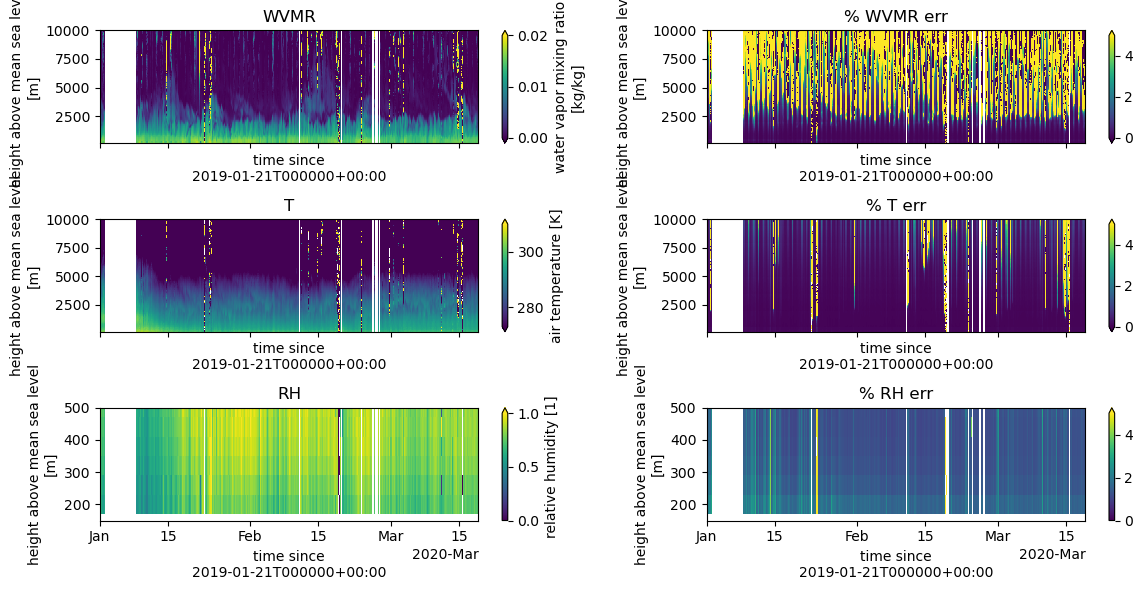

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [ ]:
# Create stacked subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axs = axs.flatten()

# Plot each xarray DataArray on its own subplot
coral_mr.plot(ax=axs[0], vmin=0e-3, vmax=20e-3)  ;                 axs[0].set_title('WVMR')
coral_ta.plot(ax=axs[2], vmin=273, vmax=310)     ;                 axs[2].set_title('T')
coral_rh.plot(ax=axs[4], vmin=0, vmax=1)         ;                 axs[4].set_title('RH')

# Plot each xarray DataArray on its own subplot
(100*mr_err/coral_mr).plot(ax=axs[1] , vmin=0, vmax=5)   ;  axs[1].set_title('% WVMR err')
(100*ta_err/coral_ta).plot(ax=axs[3] , vmin=0, vmax=5)   ;  axs[3].set_title('% T err')
(100*rh_err/coral_rh).plot(ax=axs[5] , vmin=0, vmax=5)   ;  axs[5].set_title('% RH err')

for i, ax in enumerate(axs):
    ax.set_ylim([lowest_level, highest_level])
    if i == 4 or i==5:
        ax.set_ylim([lowest_level, 500])

plt.tight_layout()
plt.show()



In [9]:
coral_ta.min().values

array(-1.6579607e+09, dtype=float32)

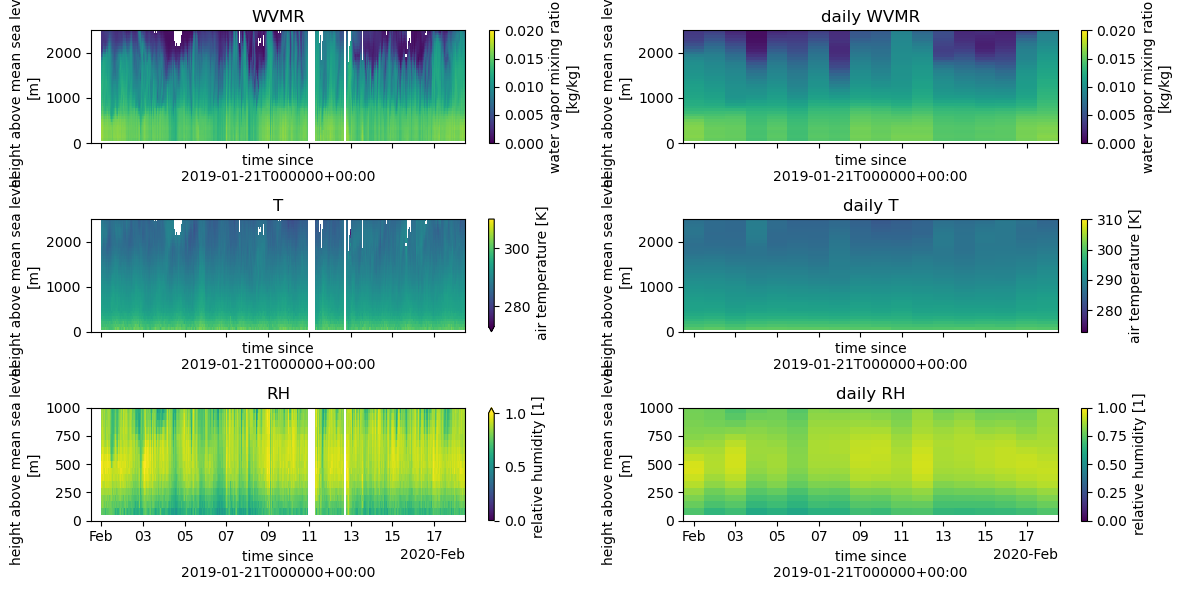

In [5]:
## --- observe what happens when averaging over time - DAILY MEANS

coral_q_day = coral_mr.resample(time='1d').mean(skipna=True)
coral_T_day = coral_ta.resample(time='1d').mean(skipna=True)
coral_rh_day = coral_rh.resample(time='1d').mean(skipna=True)


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axs = axs.flatten()

# --- Plot each xarray DataArray on its own subplot

coral_mr.plot(ax=axs[0], vmin=0e-3, vmax=20e-3)  ;                 axs[0].set_title('WVMR')
coral_ta.plot(ax=axs[2], vmin=273, vmax=310)     ;                 axs[2].set_title('T')
coral_rh.plot(ax=axs[4], vmin=0, vmax=1)         ;                 axs[4].set_title('RH')

coral_q_day.plot(ax=axs[1], vmin=0e-3, vmax=20e-3)  ;                 axs[1].set_title('daily WVMR')
coral_T_day.plot(ax=axs[3], vmin=273, vmax=310)     ;                 axs[3].set_title('daily T')
coral_rh_day.plot(ax=axs[5], vmin=0, vmax=1)        ;                 axs[5].set_title('daily RH')

for i , ax in enumerate(axs):
    ax.set_ylim([lowest_level, highest_level])
    if i == 4 or i == 5 :
        ax.set_ylim([lowest_level, 1000])



plt.tight_layout()
plt.show()


In [4]:
# --- observe some profiles of derived quantities, such as MSE



DSE     = cp*coral_ta  + g*coral_ta.alt
MSE     = DSE + Lv*coral_mr
MSE_sat     = DSE + Lv*(coral_mr/coral_rh)

DSE_day = DSE.resample(time="1d").mean(skipna=True)
MSE_day = MSE.resample(time="1d").mean(skipna=True)
MSE_sat_day = MSE_sat.resample(time="1d").mean(skipna=True)


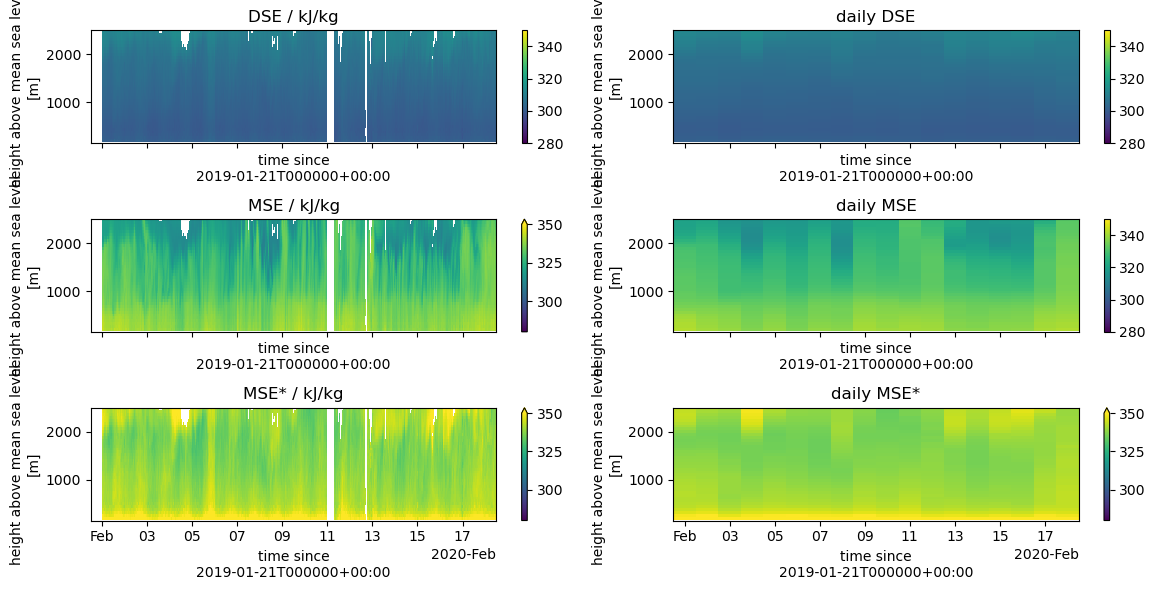

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axs = axs.flatten()

# --- Plot each xarray DataArray on its own subplot

(DSE).plot(ax=axs[0], vmin=280, vmax=350)     ;             axs[0].set_title('DSE / kJ/kg')
(MSE).plot(ax=axs[2], vmin=280, vmax=350)     ;             axs[2].set_title('MSE / kJ/kg')
(MSE_sat).plot(ax=axs[4], vmin=280, vmax=350) ;             axs[4].set_title('MSE* / kJ/kg')

(DSE_day).plot(ax=axs[1], vmin=280, vmax=350)     ;         axs[1].set_title('daily DSE')
(MSE_day).plot(ax=axs[3], vmin=280, vmax=350)     ;         axs[3].set_title('daily MSE')
(MSE_sat_day).plot(ax=axs[5], vmin=280, vmax=350) ;         axs[5].set_title('daily MSE*')


for ax in axs:
    ax.set_ylim([lowest_level, highest_level])

plt.tight_layout()
plt.show()


/tmp/ipykernel_4051681/188182614.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo')


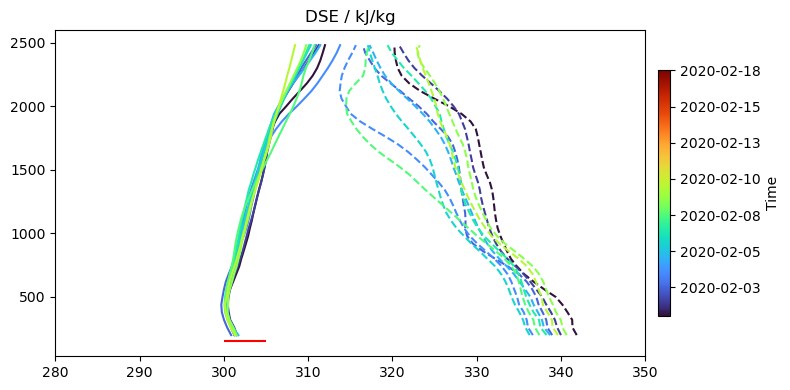

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/num

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Convert all times to Matplotlib date numbers
time_nums = mdates.date2num(DSE_day.time)

# Normalize times to 0–1 for the colormap
norm = mcolors.Normalize(vmin=time_nums.min(), vmax=time_nums.max())
cmap = cm.get_cmap('turbo')




fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharex=True)

for i in range(0,10,1):
    color = cmap(norm(time_nums[i]))  # get an RGBA color from the time
    axs.plot(DSE_day[:, i], DSE_day.alt, c=color)
    axs.plot(MSE_day[:, i], MSE_day.alt, linestyle='--', c=color)

axs.set_title('DSE / kJ/kg')
axs.hlines(y=lowest_level, xmin=300, xmax=305, color='red')

axs.set_xlim(280, 350)
# axs.set_ylim(lowest_level, highest_level)

# Add a colorbar showing the mapping between color and time
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Time')
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


the CORAL profiles start from a height of 200m

### I'm curious what is going on with MSE* over the hourly timescale 
-- it's just temperature looping

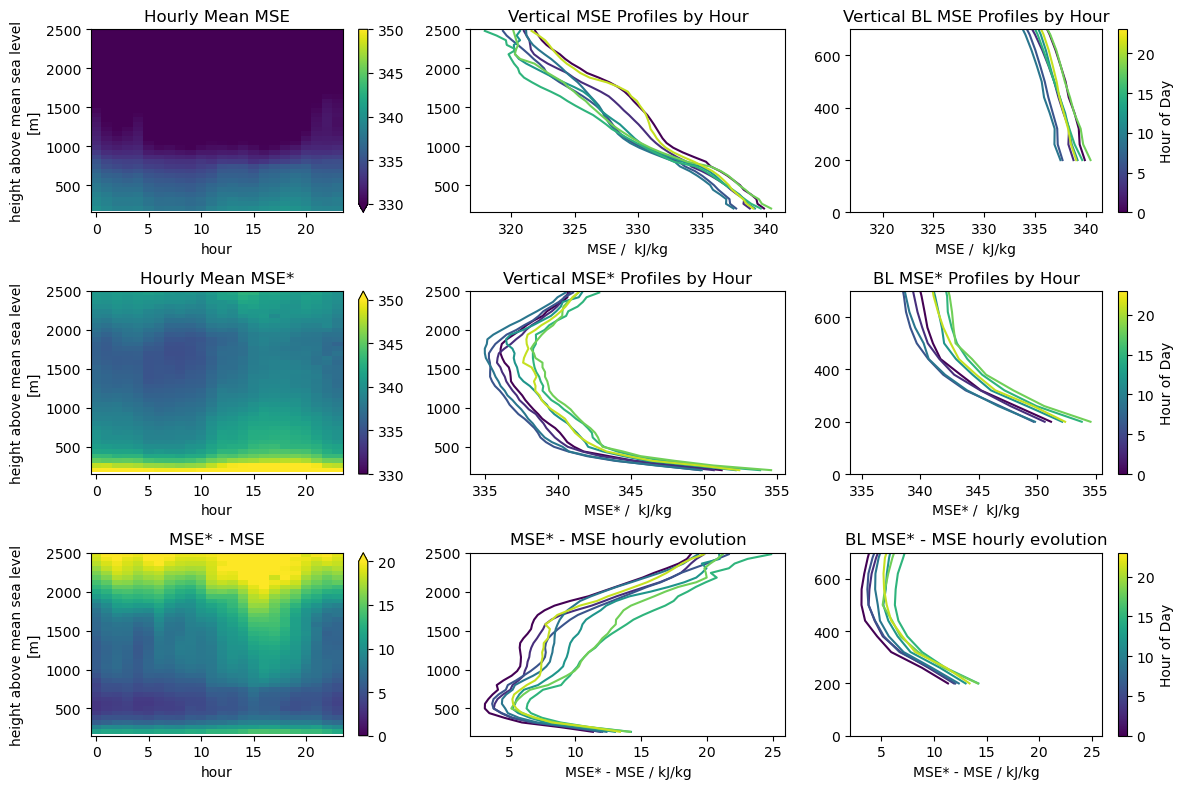

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# - buid normalized colormap based on hour of day
norm = mcolors.Normalize(vmin=0, vmax=23)
cmap = plt.colormaps["viridis"] #cm.get_cmap("viridis")  # choose any e.g. 'plasma', 'cividis', etc.


fig, ax = plt.subplots(3, 3, figsize=(12, 8))
# ax = ax.flatten()


# - hourly cycle in MSE ?
mse_h = (MSE ).resample(time="1h").mean(skipna=True).groupby("time.hour").mean(skipna=True)
mse_h.plot(ax=ax[0,0], vmin=330, vmax=350)
ax[0,0].set_title("Hourly Mean MSE")

# - MSE vertical profiles per hour
for i in range(0, 23, 3):
    hour  = mse_h.hour.values[i]
    color = cmap(norm(hour))
    ax[0,1].plot(mse_h[:, i], mse_h.alt, color=color, label=f"{hour:02d}h")

ax[0,1].set_xlabel("MSE /  kJ/kg")
ax[0,1].set_title("Vertical MSE Profiles by Hour")

# focus on BL
for i in range(0, 23, 3):
    hour  = mse_h.hour.values[i]
    color = cmap(norm(hour))
    ax[0,2].plot(mse_h[:, i], mse_h.alt, color=color, label=f"{hour:02d}h")

ax[0,2].set_xlabel("MSE /  kJ/kg")
ax[0,2].set_title("Vertical BL MSE Profiles by Hour")
ax[0,2].set_ylim(0,700)


# - Compute and plot hourly mean MSE*
mse_sat_h = (MSE_sat ).resample(time="1h").std(skipna=True).groupby("time.hour").std(skipna=True)
mse_sat_h.plot(ax=ax[1,0], vmin=330, vmax=350)
ax[1,0].set_title("Hourly std MSE*")


# - MSE* vertical profiles per hour
for i in range(0, 23, 3):
    hour  = mse_sat_h.hour.values[i]
    color = cmap(norm(hour))
    ax[1,1].plot(mse_sat_h[:, i], mse_sat_h.alt, color=color, label=f"{hour:02d}h")

ax[1,1].set_xlabel("MSE* /  kJ/kg")
ax[1,1].set_title("Vertical MSE* Profiles by Hour")

# focus on BL
for i in range(0, 23, 3):
    hour  = mse_sat_h.hour.values[i]
    color = cmap(norm(hour))
    ax[1,2].plot(mse_sat_h[:, i], mse_sat_h.alt, color=color, label=f"{hour:02d}h")

ax[1,2].set_ylim(0,700)
ax[1,2].set_xlabel("MSE* /  kJ/kg")
ax[1,2].set_title("BL MSE* Profiles by Hour")



# --- is the hourly cycle in MSE* only explainable with temperature? yes
mse_diff_h    = ( (MSE_sat - MSE) ).resample(time="1h").std(skipna=True).groupby("time.hour").std(skipna=True)
mse_diff_h.plot(ax=ax[2,0], vmin=0, vmax=20)
ax[2,0].set_title("MSE* - MSE")

# - difference
for i in range(0, 23, 3):
    hour  = mse_diff_h.hour.values[i]
    color = cmap(norm(hour))
    ax[2,1].plot(mse_diff_h[:, i], mse_diff_h.alt, color=color, label=f"{hour:02d}h")
ax[2,1].set_xlabel("MSE* - MSE / kJ/kg")
ax[2,1].set_title("MSE* - MSE hourly evolution")

# - focus on BL
for i in range(0, 23, 3):
    hour  = mse_diff_h.hour.values[i]
    color = cmap(norm(hour))
    ax[2,2].plot(mse_diff_h[:, i], mse_diff_h.alt, color=color, label=f"{hour:02d}h")
ax[2,2].set_xlabel("MSE* - MSE / kJ/kg")
ax[2,2].set_title("BL MSE* - MSE hourly evolution")
ax[2,2].set_ylim(0,700)


# - add a colorbar for hours
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])



for i,x in enumerate(ax.flatten()):
    if i%3==0 or i%3 == 1:
        x.set_ylim(lowest_level, highest_level)
    if (i+1)%3 == 0 :
        plt.colorbar(sm, ax=x, label="Hour of Day")

plt.tight_layout()
plt.show()


#### compare Lidar with radiosondes in EUREC4A


In [5]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [6]:
## --- I downloaded the Level 2 version of EUREC4A profiles
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"

import xarray as xr

ds = xr.open_dataset(level2_path)
# Create boolean index for soundings where month == 2
mask = ds.launch_time.dt.month == 2

# Select along 'sounding' dimension
ds_filtered = ds.sel(sounding=mask)
ds_filtered

<xarray.Dataset> Size: 43MB
Dimensions:      (sounding: 182, alt: 3100, nv: 2)
Coordinates:
  * sounding     (sounding) <U40 29kB 'BCO__descent__12.98_-59.27__2020020100...
  * alt          (alt) int16 6kB 0 10 20 30 40 ... 30950 30960 30970 30980 30990
    flight_time  (sounding, alt) datetime64[ns] 5MB ...
    lat          (sounding, alt) float32 2MB ...
    lon          (sounding, alt) float32 2MB ...
    launch_time  (sounding) datetime64[ns] 1kB 2020-02-01T00:12:17.439354 ......
Dimensions without coordinates: nv
Data variables: (12/19)
    p            (sounding, alt) float32 2MB ...
    dz           (sounding, alt) float32 2MB ...
    ta           (sounding, alt) float32 2MB ...
    dp           (sounding, alt) float32 2MB ...
    wspd         (sounding, alt) float32 2MB ...
    u            (sounding, alt) float32 2MB ...
    ...           ...
    rh           (sounding, alt) float32 2MB ...
    N_ptu        (sounding, alt) float32 2MB ...
    N_gps        (sounding, alt) float32 2MB ...
    m_ptu        (sounding, alt) int16 1MB ...
    m_gps        (sounding, alt) int16 1MB ...
    ascent_flag  (sounding) int16 364B ...
Attributes: (12/13)
    title:            EUREC4A level 2 sounding data
    platform:         BCO
    instrument:       Radiosonde RS41-SGP by Vaisala
    doi:              10.25326/137
    created_with:     batch_interpolate_soundings.py with its last modificati...
    created_on:       Tue Dec 22 18:54:59 2020
    ...               ...
    Conventions:      CF-1.7
    campaign_id:      EUREC4A
    references:       Stephan et al. (2020): Ship- and island-based atmospher...
    acknowledgement:  The MPI-M is listed as the institute of first contact. ...
    instrument_id:    Vaisala-RS
    version:          v3.0.0

Text(0.5, 0, 'MSE / J/g')

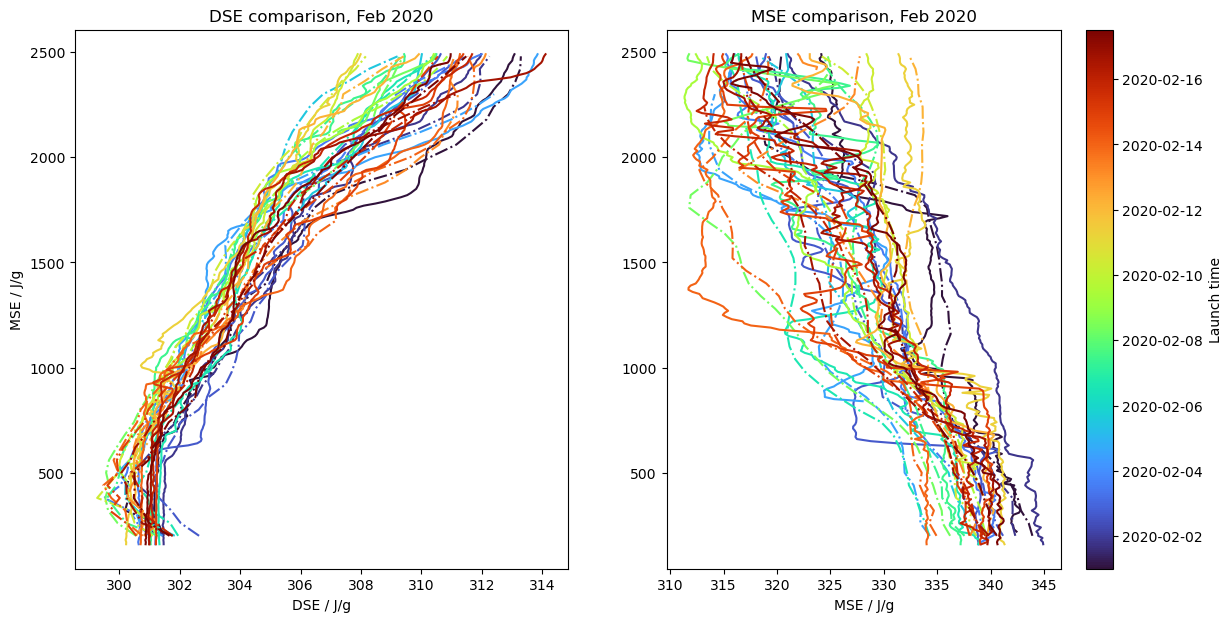

In [ ]:


# Convert launch_time to matplotlib numeric dates
time_nums = mdates.date2num(ds_filtered.launch_time.values)

# Create colormap
norm = mcolors.Normalize(vmin=time_nums.min(), vmax=time_nums.max())
cmap = plt.colormaps['turbo']


fig, ax = plt.subplots(1, 2, figsize=(14, 7))

for i, lt in enumerate(ds_filtered.launch_time[::10]):

    # Find the closest DSE profile in time
    time_sep = pd.to_timedelta(DSE.time - lt)
    closest_idx = np.argmin(np.abs(time_sep))
    closest_DSE_coral_pr = DSE.sel(time=DSE.time[closest_idx])
    closest_MSE_coral_pr = MSE.sel(time=DSE.time[closest_idx])

    # Get the sounding index for radiosonde
    sounding_idx = np.argmin(np.abs(pd.to_timedelta(ds_filtered.launch_time - lt)))

    # Compute color for this launch_time
    color = cmap(norm(mdates.date2num(lt)))

    # --- Plot coral DSE profile ---
    ax[0].plot(closest_DSE_coral_pr, closest_DSE_coral_pr.alt, linestyle='-.', color=color)
    ax[1].plot(closest_MSE_coral_pr, closest_MSE_coral_pr.alt, linestyle='-.', color=color)

    # --- Plot radiosonde profile ---
    alt_pr = ds_filtered.alt
    alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
    alt_pr = alt_pr[alt_mask]

    dse_pr = cp * (ds_filtered["ta"].isel(sounding=sounding_idx)) + g * ds_filtered.alt
    mse_pr = dse_pr + Lv*ds_filtered["mr"].isel(sounding=sounding_idx)
    
    dse_pr = dse_pr[alt_mask]
    mse_pr = mse_pr[alt_mask]

    ax[0].plot(dse_pr, alt_pr, color=color)
    ax[1].plot(mse_pr, alt_pr, color=color)


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1])
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
cbar.set_label('Launch time')

ax[0].set_title("DSE comparison, Feb 2020")
ax[0].set_xlabel(r"DSE / J/g")
ax[0].set_ylabel(r"MSE / J/g")

ax[1].set_title("MSE comparison, Feb 2020")
ax[1].set_xlabel(r"MSE / J/g")



Text(0.5, 0, 'MSE / J/g')

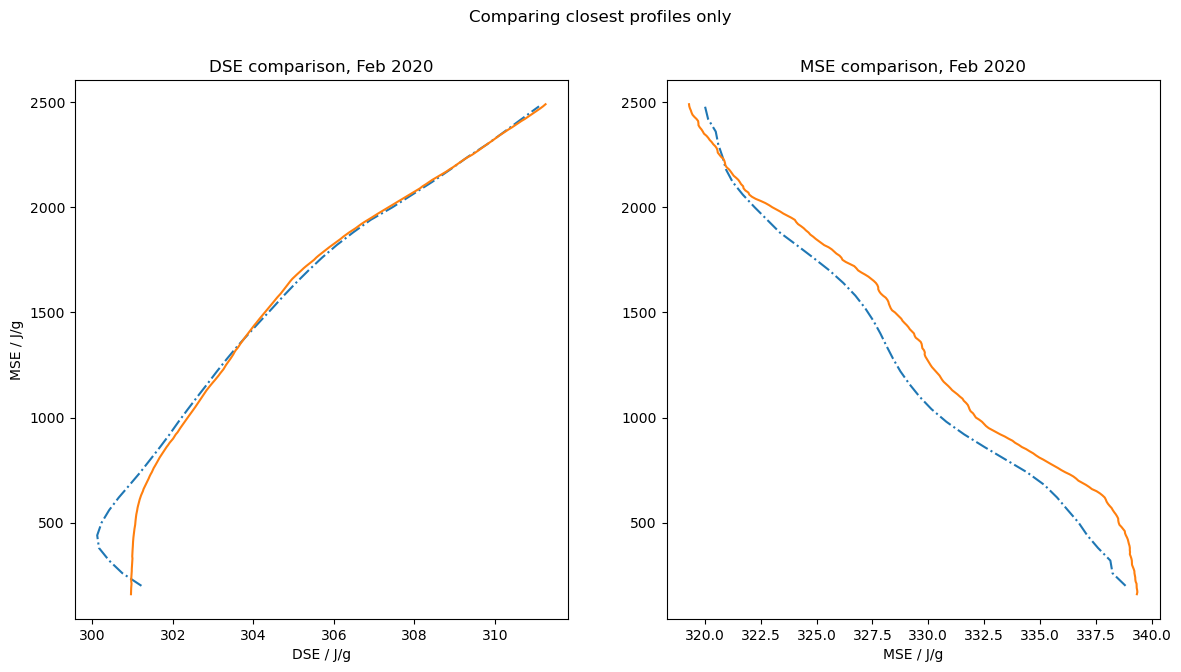

In [ ]:

# Convert launch_time to matplotlib numeric dates
time_nums = mdates.date2num(ds_filtered.launch_time.values)



fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Comparing closest profiles only")


# - collect index of closest profiles all in one list
closest_indices = []
for i, lt in enumerate(ds_filtered.launch_time):

    # Find the closest DSE profile in time
    time_sep = pd.to_timedelta(DSE.time - lt)
    closest_idx = np.argmin(np.abs(time_sep))
    closest_indices.append(closest_idx)


closest_DSE_coral_std = DSE.sel(time=DSE.time[closest_indices]).mean(dim="time", skipna=True)
closest_MSE_coral_mean = MSE.sel(time=DSE.time[closest_indices]).mean(dim="time", skipna=True)


# --- Plot coral DSE profile ---
ax[0].plot(closest_DSE_coral_mean , closest_DSE_coral_mean.alt, linestyle='-.')
ax[1].plot(closest_MSE_coral_mean , closest_MSE_coral_mean.alt, linestyle='-.')

# --- Plot radiosonde profile ---
alt_pr = ds_filtered.alt
alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
alt_pr = alt_pr[alt_mask]

dse_pr = (cp * (ds_filtered["ta"]) + g * ds_filtered.alt).mean(dim="sounding", skipna=True)
mse_pr = (cp * (ds_filtered["ta"]) + g * ds_filtered.alt + Lv*ds_filtered["mr"]).mean(dim="sounding", skipna=True)

dse_pr = dse_pr[alt_mask]
mse_pr = mse_pr[alt_mask]

ax[0].plot(dse_pr , alt_pr)
ax[1].plot(mse_pr , alt_pr)


ax[0].set_title("DSE comparison, Feb 2020")
ax[0].set_xlabel(r"DSE / J/g")
ax[0].set_ylabel(r"MSE / J/g")

ax[1].set_title("MSE comparison, Feb 2020")
ax[1].set_xlabel(r"MSE / J/g")



In [18]:
# --- build profiles of saturated MSE

MSE_pr_sat  = cp*(ds_filtered["ta"]) + g * ds_filtered.alt + Lv*(ds_filtered["mr"]/ds_filtered["rh"])

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: Run

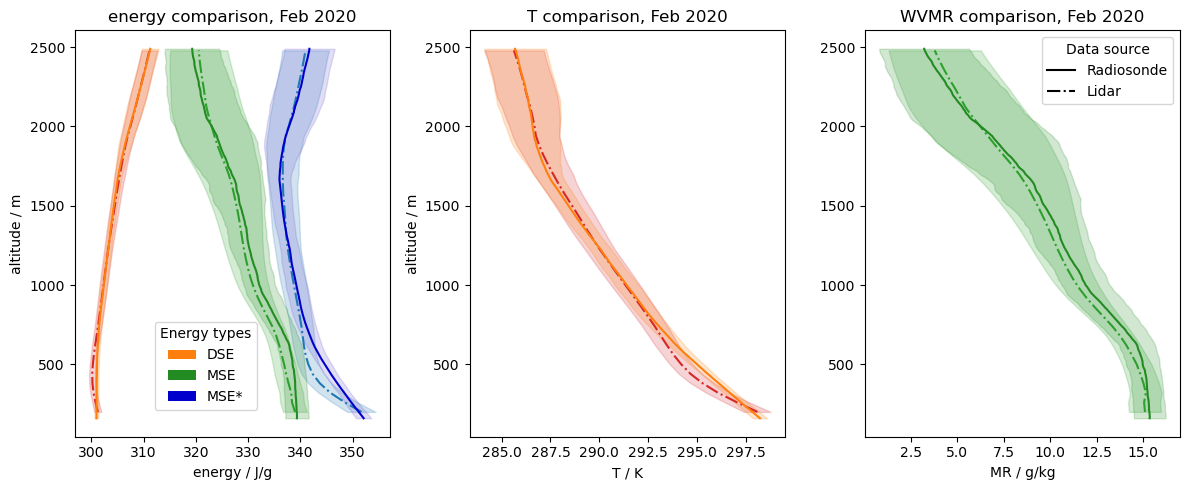

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
# ax = ax.flatten()

# --- Plot coral DSE profile ---
DSE_mean = DSE.mean(dim='time', skipna=True)
MSE_mean = MSE.mean(dim='time', skipna=True)
MSE_sat_mean = MSE_sat.mean(dim='time', skipna=True)

ax[0].plot( DSE_mean, DSE.alt, linestyle='-.', color="tab:red")
ax[0].plot( MSE_mean , MSE.alt, linestyle='-.', color="tab:green")
ax[0].plot( MSE_sat_mean , MSE.alt, linestyle='-.', color="tab:blue")


DSE_std  = DSE.std(dim='time', skipna=True)
MSE_std  = MSE.std(dim='time', skipna=True)
MSE_sat_std = MSE_sat.std(dim='time', skipna=True)


ax[0].fill_betweenx(
    DSE.alt,
    (DSE_mean - DSE_std) ,
    (DSE_mean + DSE_std) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[0].fill_betweenx(
    MSE.alt,
    (MSE_mean - MSE_std) ,
    (MSE_mean + MSE_std) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax[0].fill_betweenx(
    MSE_sat.alt,
    (MSE_sat_mean - MSE_sat_std) ,
    (MSE_sat_mean + MSE_sat_std) ,
    color="tab:blue",
    alpha=0.2,
    label='±1 std (time)'
)




# --- Plot radiosonde profile ---
# alt_pr = ds_filtered.alt
# alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
# alt_pr = alt_pr[alt_mask]

# dse_pr_mean = cp * (ds_filtered["ta"].mean(dim="sounding", skipna=True)) + g * ds_filtered.alt
# mse_pr_mean = dse_pr_mean + Lv*ds_filtered["mr"].mean(dim="sounding", skipna=True)
# mse_pr_sat_mean = MSE_pr_sat.mean(dim="sounding", skipna=True)

# dse_pr_std = cp * (ds_filtered["ta"].std(dim="sounding", skipna=True))
# mse_pr_std = (cp*ds_filtered["ta"]+Lv*ds_filtered["mr"]).std(dim="sounding", skipna=True)
# mse_pr_sat_std = MSE_pr_sat.std(dim="sounding", skipna=True)

# dse_pr_mean = dse_pr_mean[alt_mask]
# mse_pr_mean = mse_pr_mean[alt_mask]
# mse_pr_sat_mean = mse_pr_sat_mean[alt_mask]

# ax[0].plot(dse_pr_mean / 1e3, alt_pr, color="tab:orange")
# ax[0].plot(mse_pr_mean / 1e3, alt_pr, color="forestgreen")
# ax[0].plot(mse_pr_sat_mean / 1e3, alt_pr, color="mediumblue")


# ax[0].fill_betweenx(
#     alt_pr,
#     (dse_pr_mean - dse_pr_std) / 1e3,
#     (dse_pr_mean + dse_pr_std) / 1e3,
#     color="tab:orange",
#     alpha=0.2
# )

# ax[0].fill_betweenx(
#     alt_pr,
#     (mse_pr_mean - mse_pr_std) / 1e3,
#     (mse_pr_mean + mse_pr_std) / 1e3,
#     color="forestgreen",
#     alpha=0.2
# )

# ax[0].fill_betweenx(
#     alt_pr,
#     (mse_pr_sat_mean - mse_pr_sat_std) / 1e3,
#     (mse_pr_sat_mean + mse_pr_sat_std) / 1e3,
#     color="slateblue",
#     alpha=0.2
# )


# ax[0].set_title("energy comparison, Feb 2020")
# ax[0].set_xlabel(r"energy / J/g")
# ax[0].set_ylabel(r"altitude / m")


# - build color legend
from matplotlib.patches import Patch

# Define your legend colors and labels
legend_info = {
    "tab:orange": ("DSE"),
    "forestgreen": ("MSE"),
    "mediumblue": ("MSE*")
}

# Build custom legend handles
legend_elements = [
    Patch(facecolor=color, label=f"{label}")
    for color, (label) in legend_info.items()
]

ax[0].legend(handles=legend_elements, title="Energy types", loc="best", bbox_to_anchor=(0.3, 0., 0.3, 0.3))





# --- plot CORAL temperature and moisture profiles alone here
q_mean = coral_mr.mean(dim='time', skipna=True)
T_mean = coral_ta.mean(dim='time', skipna=True)

ax[2].plot( q_mean*1e3 , q_mean.alt, linestyle='-.', color="tab:green")
ax[1].plot( T_mean , T_mean.alt, linestyle='-.', color="tab:red")

q_std  = coral_mr.std(dim='time', skipna=True)
T_std  = coral_ta.std(dim='time', skipna=True)


ax[2].fill_betweenx(
    coral_mr.alt,
    (q_mean - q_std)*1e3,
    (q_mean + q_std)*1e3,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax[1].fill_betweenx(
    coral_ta.alt,
    (T_mean - T_std),
    (T_mean + T_std),
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)


# --- Plot temperature and moisture from radiosonde profile ---
alt_pr = ds_filtered.alt
alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
alt_pr = alt_pr[alt_mask]

T_pr_mean = ds_filtered["ta"].mean(dim="sounding", skipna=True)
q_pr_mean = ds_filtered["mr"].mean(dim="sounding", skipna=True)

T_pr_std = ds_filtered["ta"].std(dim="sounding", skipna=True)
q_pr_std = ds_filtered["mr"].std(dim="sounding", skipna=True)

T_pr_mean = T_pr_mean[alt_mask]
q_pr_mean = q_pr_mean[alt_mask]

ax[2].plot(q_pr_mean*1e3 , alt_pr, color="forestgreen")
ax[1].plot(T_pr_mean , alt_pr, color="tab:orange")


ax[2].fill_betweenx(
    alt_pr,
    (q_pr_mean - q_pr_std)*1e3,
    (q_pr_mean + q_pr_std)*1e3,
    color="forestgreen",
    alpha=0.2
)

ax[1].fill_betweenx(
    alt_pr,
    (T_pr_mean - T_pr_std),
    (T_pr_mean + T_pr_std),
    color="tab:orange",
    alpha=0.2
)


ax[2].set_title("WVMR comparison, Feb 2020")
ax[2].set_xlabel(r"MR / g/kg")

ax[1].set_title("T comparison, Feb 2020")
ax[1].set_xlabel(r"T / K")
ax[1].set_ylabel(r"altitude / m")


# - build Lidar vs profile legends
custom_lines = [
    Line2D([0], [0], color='k', linestyle='-', label='Radiosonde'),   # solid line
    Line2D([0], [0], color='k', linestyle='-.', label='Lidar')        # dash-dot line
]

# Add the legend only to ax[2]
ax[2].legend(handles=custom_lines, loc='best', title='Data source')


plt.tight_layout()
plt.show()

In [46]:
# - compare actual profiles with those corrected by Ilya

import glob
import xarray as xr

files = glob.glob("CORAL_eurec4a_postprocessed/*.nc")
files = sorted(files)

corrected_coral = xr.open_mfdataset(files, combine='by_coords').sel(time=slice("2020-02-01", "2020-02-18"))
corrected_coral

/tmp/ipykernel_2182633/2647075267.py:9: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  corrected_coral = xr.open_mfdataset(files, combine='by_coords').sel(time=slice("2020-02-01", "2020-02-18"))


<xarray.Dataset> Size: 251MB
Dimensions:    (time: 12960, alt: 484, lim: 2)
Coordinates:
  * time       (time) datetime64[ns] 104kB 2020-02-01 ... 2020-02-18T23:58:00
  * alt        (alt) float32 2kB 20.0 80.0 140.0 ... 2.888e+04 2.894e+04 2.9e+04
Dimensions without coordinates: lim
Data variables:
    lon        (time) float32 52kB -59.43 -59.43 -59.43 ... -59.43 -59.43 -59.43
    lat        (time) float32 52kB 13.16 13.16 13.16 13.16 ... 13.16 13.16 13.16
    alt_bnds   (time, alt, lim) float32 50MB dask.array<chunksize=(1, 484, 2), meta=np.ndarray>
    ta         (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    ta_err     (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    dtadz      (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    dtadz_err  (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    mr         (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    mr_err     (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    rh         (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
    rh_err     (time, alt) float32 25MB dask.array<chunksize=(1, 484), meta=np.ndarray>
Attributes: (12/21)
    title:                        water vapor, temperature, humidity, tempera...
    campaign:                     EUREC4A
    platform:                     BCO
    instrument:                   CORAL-LIDAR
    institution:                  Max Planck Institute for Meteorology, Hamburg
    altitude_meter_asl:           20.0
    ...                           ...
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   3600.0
    license:                      to be defined
    history:                      created by Ilya Serikov (ilya.serikov@mpime...
    version:                      1.0.0
    Conventions:                  CF-1.7

In [ ]:
# Extract variables
corr_mr, corr_mr_err     = corrected_coral['mr'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , corrected_coral['mr_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
corr_ta, corr_ta_err     = corrected_coral['ta'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , corrected_coral['ta_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
corr_rh, corr_rh_err     = corrected_coral['rh'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , corrected_coral['rh_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))

# strange values in e.g. slice("2020-02-19T00:58:00", "2020-02-19T15:58:00")
# --- clean unreasonable values

accept_mask = (corr_mr>0.)&(corr_mr<25e-3)&(corr_mr_err/corr_mr < 5e-2)&(corr_ta>0.)&(corr_ta<350)&(corr_ta_err/corr_ta < 5e-2)

corr_mr = corr_mr.where(accept_mask)
corr_ta = corr_ta.where(accept_mask)
corr_rh = corr_rh.where(accept_mask)

cp = 1.004   # J / g K
Lv = 2.5e3  # J / g
g  = 9.81   # m/s2  

corr_DSE      = cp*corr_ta  + g*corr_ta.alt
corr_MSE      = corr_DSE + Lv*corr_mr
corr_MSE_sat  = corr_DSE + Lv*(corr_mr/corr_rh)




In [48]:
# compute data here
DSE_mean = DSE.mean(dim="time", skipna=True)
DSE_std  = DSE.std(dim='time', skipna=True)

corr_DSE_mean = corr_DSE.mean(dim="time", skipna=True)
corr_DSE_std  = corr_DSE.std(dim='time', skipna=True)

ds_lowProf = ds_filtered.sel(alt=slice(0, highest_level))
dse_pr_mean = cp * (ds_lowProf["ta"].mean(dim="sounding", skipna=True)) + g * ds_lowProf.alt
dse_pr_std = cp * (ds_lowProf["ta"].std(dim="sounding", skipna=True))



# --- MSE quantities

MSE_mean = MSE.mean(dim="time", skipna=True)
MSE_std  = MSE.std(dim='time', skipna=True)

corr_MSE_mean = corr_MSE.mean(dim="time", skipna=True)
corr_MSE_std  = corr_MSE.std(dim='time', skipna=True)

ds_lowProf = ds_filtered.sel(alt=slice(0, highest_level))
mse_pr_mean = cp * (ds_lowProf["ta"].mean(dim="sounding", skipna=True)) + g * ds_lowProf.alt + Lv * (ds_lowProf["mr"].mean(dim="sounding", skipna=True))
mse_pr_std = cp * (ds_lowProf["ta"].std(dim="sounding", skipna=True)) + Lv * (ds_lowProf["mr"].std(dim="sounding", skipna=True))

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [49]:
time_sel_wxt = slice("2020-02-01", "2020-02-18")

wxt_dse = cp*temp.sel(time=time_sel_wxt)
wxt_dse_mean = wxt_dse.sel(time=wxt_dse.time.dt.minute == 30).mean(dim="time")
wxt_dse_std = wxt_dse.sel(time=wxt_dse.time.dt.minute == 30).std(dim="time")


wxt_mse = (cp*temp + Lv*q).sel(time=time_sel_wxt)
wxt_mse_mean = wxt_mse.sel(time=wxt_mse.time.dt.minute == 30).mean(dim="time")
wxt_mse_std = wxt_mse.sel(time=wxt_mse.time.dt.minute == 30).std(dim="time")

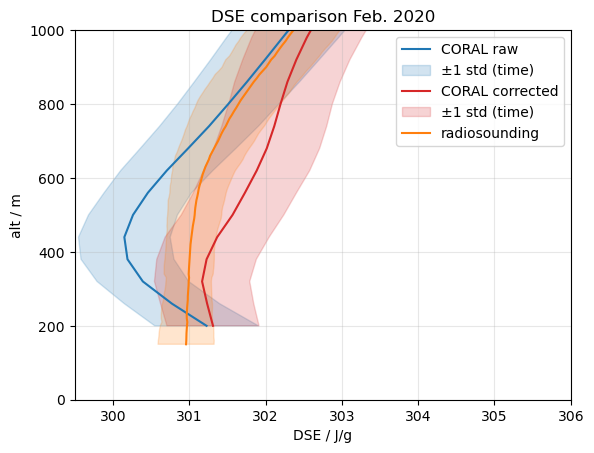

In [ ]:


# - wrx surface DSE and MSE values
plt.plot()


plt.plot(DSE_mean, DSE.alt, color="tab:blue", label="CORAL raw")
plt.fill_betweenx(
    DSE.alt,
    (DSE_mean - DSE_std) ,
    (DSE_mean + DSE_std) ,
    color="tab:blue",
    alpha=0.2,
    label='±1 std (time)'
)


plt.plot(corr_DSE_mean, corr_DSE.alt, color="tab:red", label="CORAL corrected")
plt.fill_betweenx(
    corr_DSE.alt,
    (corr_DSE_mean - corr_DSE_std) ,
    (corr_DSE_mean + corr_DSE_std) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)



# radiosonde profile
plt.plot(dse_pr_mean , dse_pr_mean.alt, color="tab:orange", label="radiosounding")
plt.fill_betweenx(
    dse_pr_mean.alt,
    (dse_pr_mean - dse_pr_std) ,
    (dse_pr_mean + dse_pr_std) ,
    color="tab:orange",
    alpha=0.2
)

plt.ylim(0,1000)
plt.xlim(299.5, 306)
plt.xlabel("DSE / J/g")
plt.ylabel("alt / m")
plt.title("DSE comparison Feb. 2020")
plt.grid(alpha=0.3)
plt.legend()

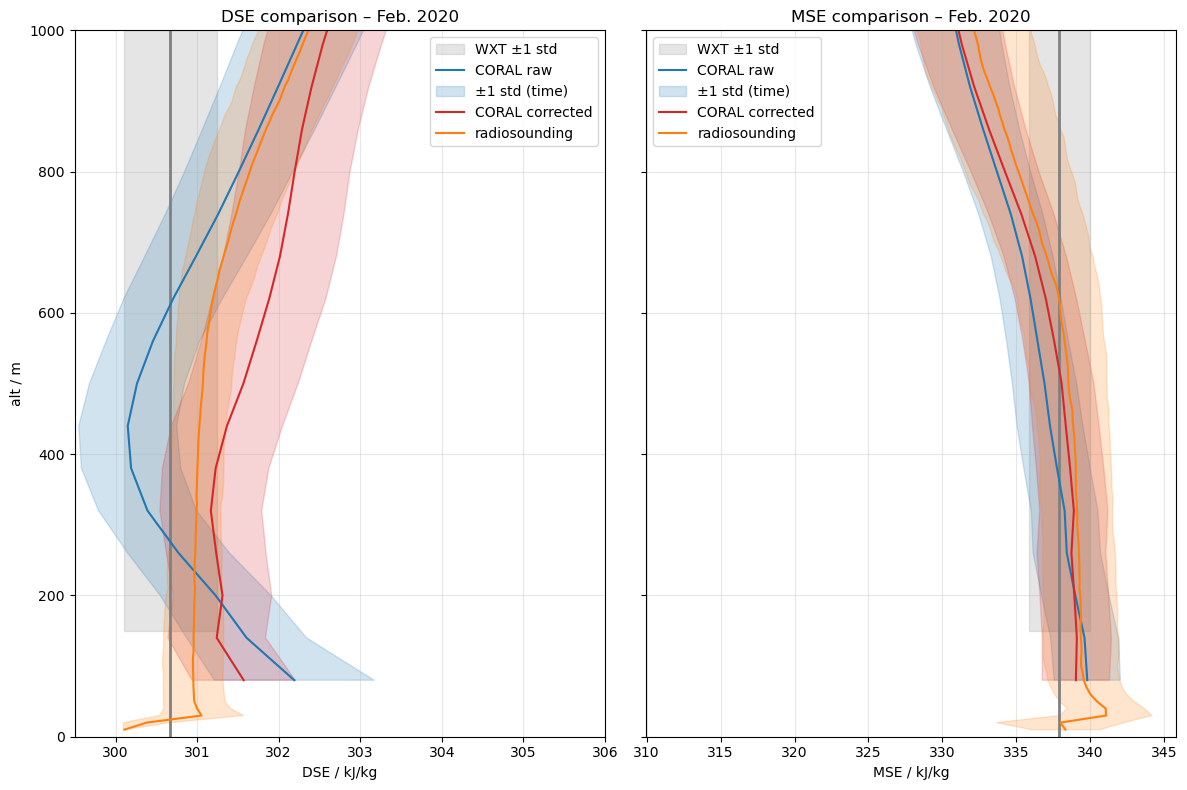

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# =============================================================
# ==========================  DSE  =============================
# =============================================================

# WXT vertical band: mean ± std between 150–1000 m
ax[0].axvspan(
    (wxt_dse_mean - wxt_dse_std) ,
    (wxt_dse_mean + wxt_dse_std) ,
    ymin=150/1000, ymax=1000/1000,
    color="gray", alpha=0.2, label="WXT ±1 std"
)

# Mean line for WXT (vertical)
ax[0].vlines(wxt_dse_mean , ymin=0, ymax=1000, color="gray", linewidth=2)

# CORAL raw
ax[0].plot(DSE_mean , DSE.alt, color="tab:blue", label="CORAL raw")
ax[0].fill_betweenx(
    DSE.alt,
    (DSE_mean - DSE_std),
    (DSE_mean + DSE_std) ,
    color="tab:blue", alpha=0.2, label="±1 std (time)"
)

# - CORAL corrected
ax[0].plot(corr_DSE_mean , corr_DSE.alt, color="tab:red", label="CORAL corrected")
ax[0].fill_betweenx(
    corr_DSE.alt,
    (corr_DSE_mean - corr_DSE_std) ,
    (corr_DSE_mean + corr_DSE_std) ,
    color="tab:red", alpha=0.2
)

# Radiosonde
ax[0].plot(dse_pr_mean , dse_pr_mean.alt, color="tab:orange", label="radiosounding")
ax[0].fill_betweenx(
    dse_pr_mean.alt,
    (dse_pr_mean - dse_pr_std) ,
    (dse_pr_mean + dse_pr_std) ,
    color="tab:orange", alpha=0.2
)

# Formatting
ax[0].set_ylim(0, 1000)
ax[0].set_xlim(299.5, 306)
ax[0].set_xlabel("DSE / kJ/kg")
ax[0].set_ylabel("alt / m")
ax[0].set_title("DSE comparison – Feb. 2020")
ax[0].grid(alpha=0.3)
ax[0].legend()


# =============================================================
# ==========================  MSE  =============================
# =============================================================

# WXT vertical band: mean ± std between 150–1000 m
ax[1].axvspan(
    (wxt_mse_mean - wxt_mse_std) ,
    (wxt_mse_mean + wxt_mse_std) ,
    ymin=150/1000, ymax=1000/1000,
    color="gray", alpha=0.2, label="WXT ±1 std"
)

# Mean line for WXT
ax[1].vlines(wxt_mse_mean , ymin=0, ymax=1000, color="gray", linewidth=2)

# CORAL raw
ax[1].plot(MSE_mean , MSE.alt, color="tab:blue", label="CORAL raw")
ax[1].fill_betweenx(
    MSE.alt,
    (MSE_mean - MSE_std) ,
    (MSE_mean + MSE_std) ,
    color="tab:blue", alpha=0.2, label="±1 std (time)"
)

# CORAL corrected
ax[1].plot(corr_MSE_mean , corr_MSE.alt, color="tab:red", label="CORAL corrected")
ax[1].fill_betweenx(
    corr_MSE.alt,
    (corr_MSE_mean - corr_MSE_std) ,
    (corr_MSE_mean + corr_MSE_std) ,
    color="tab:red", alpha=0.2
)

# Radiosonde
ax[1].plot(mse_pr_mean , mse_pr_mean.alt, color="tab:orange", label="radiosounding")
ax[1].fill_betweenx(
    mse_pr_mean.alt,
    (mse_pr_mean - mse_pr_std) ,
    (mse_pr_mean + mse_pr_std) ,
    color="tab:orange", alpha=0.2
)

# Formatting
ax[1].set_ylim(0, 1000)
# ax[1].set_xlim(299.5, 306)
ax[1].set_xlabel("MSE / kJ/kg")
ax[1].set_title("MSE comparison – Feb. 2020")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()


## compare CORAL with ERA5 estimates

In [7]:
BCO_lon = -59.4288
BCO_lat = 13.1627

# - set control volume edges
vol_lon = [BCO_lon-0.5+360 , BCO_lon+1.3+360]  #[-60+360, -58+360]
vol_lat = [BCO_lat-0.5     , BCO_lat+1.3]  #[12.5, 14.5]

In [8]:
# - other variables from ERA5
# - filenames be like : E5pl00_1D_2024-11_131.grb
# NO NC4 AVAILABLE HERE !!
path_era5_vars = "/pool/data/ERA5/E5/pl/an/1D/"
vars_pars = {"T":"130", "U":"131", "V":"132", "q":"133", "W":"135", "div":"155"}

import intake 
cat = intake.open_catalog("https://gitlab.dkrz.de/data-infrastructure-services/era5-kerchunks/-/raw/main/main.yaml")
list(cat)

era5 = cat["pressure-level_analysis_daily"].to_dask()

# - lat lon selection
mask = ((era5.lon >= vol_lon[0]) & (era5.lon <= vol_lon[1]) &
        (era5.lat >= vol_lat[0]) & (era5.lat <= vol_lat[1])).compute()

cell_indices = np.where(mask)[0]
era5 = era5.isel(cell=cell_indices)

era5

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 5GB
Dimensions:  (time: 30955, level: 37, cell: 42)
Coordinates:
  * time     (time) datetime64[ns] 248kB 1940-01-01T11:30:00 ... 2024-09-30T1...
  * level    (level) int64 296B 1 2 3 5 7 10 20 ... 850 875 900 925 950 975 1000
    lat      (cell) float64 336B dask.array<chunksize=(42,), meta=np.ndarray>
    lon      (cell) float64 336B dask.array<chunksize=(42,), meta=np.ndarray>
Dimensions without coordinates: cell
Data variables: (12/14)
    ciwc     (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    crwc     (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    cswc     (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    d        (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    o3       (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    pv       (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    ...       ...
    t        (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    u        (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    v        (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    vo       (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    w        (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
    z        (time, level, cell) float64 385MB dask.array<chunksize=(5, 5, 42), meta=np.ndarray>
Attributes: (12/22)
    project:              ECMWF Re-Analysis
    project_id:           ERA
    institution_id:       ECMWF-DKRZ
    institution:          Data from European Centre for Medium-Range Weather ...
    source_id:            IFS
    source:               ECMWF Integrated Forecast System (IFS) CY41R2
    ...                   ...
    format:               kerchunk
    product:              reanalysis
    responsible_persons:  Angelika Heil, Fabian Wachsmann
    title:                The DKRZ ERA5 data pool. Generated using Copernicus...
    license:              The ERA5 data are published with the Copernicus Pro...
    references:           Hersbach, H., Bell, B., Berrisford, P., Hirahara, S...

In [9]:
# - time selection -- select same window as Lidar
era5 = era5.sel(time=slice('2020-02-01','2020-02-18'))

In [10]:
from metpy.units import units

height = mpcalc.pressure_to_height_std(
    era5.level.values * units("hPa")
).to(units.meter).magnitude       

height_da = xr.DataArray(height, dims=["level"], coords={"level": era5.level})

era5_dse = cp*era5["t"] + g*height_da
era5_mse = era5_dse + Lv*era5["q"]
era5_mseSat = era5_dse + Lv*era5["q"]/(xr.where(era5["r"] > 100, 100, era5["r"])/100)

In [11]:
era5_dse_mean = era5_dse.mean(dim="cell")
era5_mse_mean = era5_mse.mean(dim="cell")
era5_mseSat_mean = era5_mseSat.mean(dim="cell")


era5_dse_std = era5_dse.std(dim="cell")
era5_mse_std = era5_mse.std(dim="cell")
era5_mseSat_std = era5_mseSat.std(dim="cell")

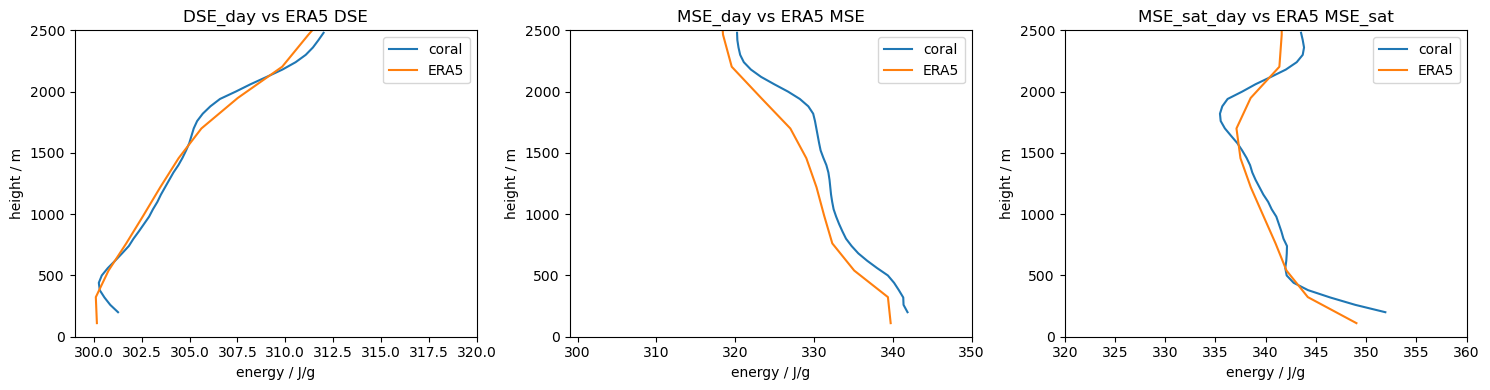

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/num

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
day = int(0)

axes[0].plot(DSE_day[:,day]/1e3,     DSE_day.alt, label="coral")
axes[1].plot(MSE_day[:,day]/1e3,     MSE_day.alt, label="coral")
axes[2].plot(MSE_sat_day[:,day]/1e3, MSE_sat_day.alt, label="coral")

axes[0].plot(era5_dse_mean[day]/1e3,     height, label="ERA5")
axes[1].plot(era5_mse_mean[day]/1e3,     height, label="ERA5")
axes[2].plot(era5_mseSat_mean[day]/1e3, height, label="ERA5")

axes[0].set_title("DSE_day vs ERA5 DSE")
axes[1].set_title("MSE_day vs ERA5 MSE")
axes[2].set_title("MSE_sat_day vs ERA5 MSE_sat")

for ax in axes:
    ax.set_xlabel("energy / J/g")
    ax.set_ylabel("height / m")
    ax.set_ylim(0,2500)
    ax.legend()

axes[0].set_xlim(299, 320)
axes[1].set_xlim(299, 350)
axes[2].set_xlim(320, 360)

plt.tight_layout()

plt.show()


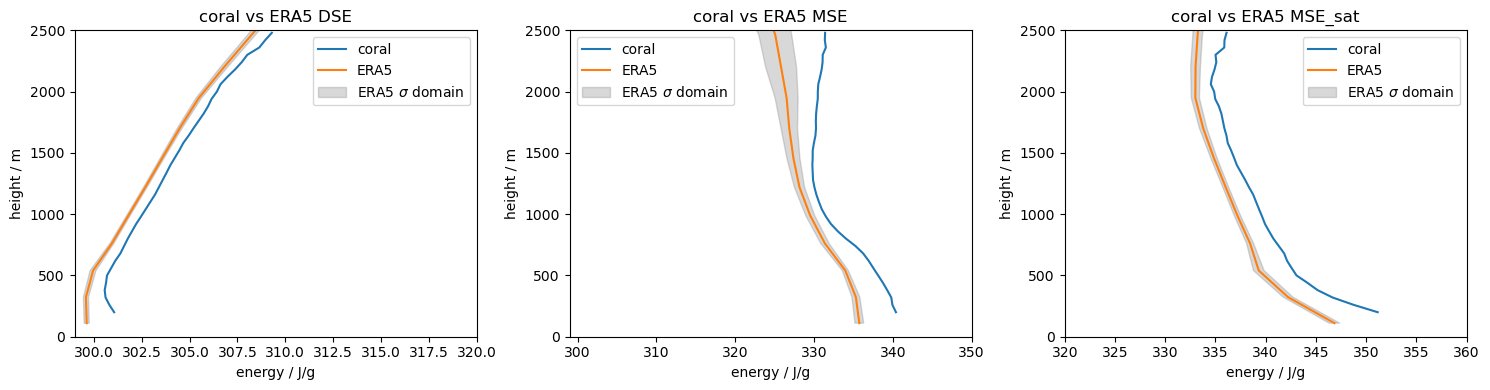

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/num

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
day = int(10)

# --------------------------
# Main line plots
# --------------------------
axes[0].plot(DSE_day[:,day]/1e3,     DSE_day.alt, label="coral")
axes[1].plot(MSE_day[:,day]/1e3,     MSE_day.alt, label="coral")
axes[2].plot(MSE_sat_day[:,day]/1e3, MSE_sat_day.alt, label="coral")





axes[0].plot(era5_dse_mean[day]/1e3,    height, label="ERA5")
axes[1].plot(era5_mse_mean[day]/1e3,    height, label="ERA5")
axes[2].plot(era5_mseSat_mean[day]/1e3, height, label="ERA5")

# --------------------------
# Add standard-deviation shading
# --------------------------
axes[0].fill_betweenx(
    height,
    (era5_dse_mean[day] - era5_dse_std[day])/1e3 ,
    (era5_dse_mean[day] + era5_dse_std[day])/1e3 ,
    color="gray", alpha=0.3, label=r"ERA5 $\sigma$ domain"
)

axes[1].fill_betweenx(
    height,
    (era5_mse_mean[day] - era5_mse_std[day])/1e3 ,
    (era5_mse_mean[day] + era5_mse_std[day])/1e3 ,
    color="gray", alpha=0.3, label=r"ERA5 $\sigma$ domain"
)

axes[2].fill_betweenx(
    height,
    (era5_mseSat_mean[day] - era5_mseSat_std[day])/1e3 ,
    (era5_mseSat_mean[day] + era5_mseSat_std[day])/1e3 ,
    color="gray", alpha=0.3, label=r"ERA5 $\sigma$ domain"
)

# --------------------------
# Formatting
# --------------------------
axes[0].set_title("coral vs ERA5 DSE")
axes[1].set_title("coral vs ERA5 MSE")
axes[2].set_title("coral vs ERA5 MSE_sat")

for ax in axes:
    ax.set_xlabel("energy / J/g")
    ax.set_ylabel("height / m")
    ax.set_ylim(0,2500)
    ax.legend()

axes[0].set_xlim(299, 320)
axes[1].set_xlim(299, 350)
axes[2].set_xlim(320, 360)

plt.tight_layout()
plt.show()


In [12]:
# - run computations for radiosonde profiles
alt_pr = ds_filtered.alt
alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
alt_pr = alt_pr[alt_mask]

dse_pr_mean = cp * (ds_filtered["ta"].mean(dim="sounding", skipna=True)) + g * ds_filtered.alt
mse_pr_mean = dse_pr_mean + Lv*ds_filtered["mr"].mean(dim="sounding", skipna=True)
MSE_pr_sat  = cp*(ds_filtered["ta"]) + g * ds_filtered.alt + Lv*(ds_filtered["mr"]/ds_filtered["rh"])
mse_pr_sat_mean = MSE_pr_sat.mean(dim="sounding", skipna=True)

dse_pr_std = cp * (ds_filtered["ta"].std(dim="sounding", skipna=True))
mse_pr_std = (cp*ds_filtered["ta"]+Lv*ds_filtered["mr"]).std(dim="sounding", skipna=True)
mse_pr_sat_std = MSE_pr_sat.std(dim="sounding", skipna=True)

dse_pr_mean = dse_pr_mean[alt_mask]
mse_pr_mean = mse_pr_mean[alt_mask]
mse_pr_sat_mean = mse_pr_sat_mean[alt_mask]

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


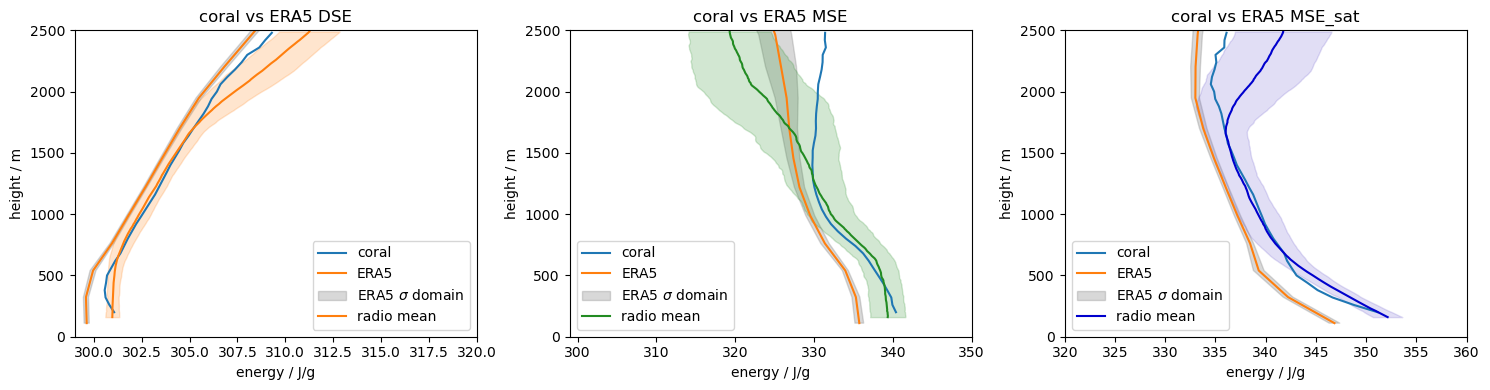

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
day = int(10)

# --------------------------
# Main line plots
# --------------------------
axes[0].plot(DSE_day[:,day]/1e3,     DSE_day.alt, label="coral", color="tab:orange")
axes[1].plot(MSE_day[:,day]/1e3,     MSE_day.alt, label="coral", color="tab:orange")
axes[2].plot(MSE_sat_day[:,day]/1e3, MSE_sat_day.alt, label="coral", color="tab:orange")

axes[0].plot(era5_dse_mean[day]/1e3,    height, label="ERA5", color="tab:blue")
axes[1].plot(era5_mse_mean[day]/1e3,    height, label="ERA5", color="tab:blue")
axes[2].plot(era5_mseSat_mean[day]/1e3, height, label="ERA5", color="tab:blue")

# --------------------------
# Add standard-deviation shading
# --------------------------
axes[0].fill_betweenx(
    height,
    (era5_dse_mean[day] - era5_dse_std[day])/1e3 ,
    (era5_dse_mean[day] + era5_dse_std[day])/1e3 ,
    color="gray", alpha=0.3, label=r"ERA5 $\sigma$ domain"
)

axes[1].fill_betweenx(
    height,
    (era5_mse_mean[day] - era5_mse_std[day])/1e3 ,
    (era5_mse_mean[day] + era5_mse_std[day])/1e3 ,
    color="gray", alpha=0.3, label=r"ERA5 $\sigma$ domain"
)

axes[2].fill_betweenx(
    height,
    (era5_mseSat_mean[day] - era5_mseSat_std[day])/1e3 ,
    (era5_mseSat_mean[day] + era5_mseSat_std[day])/1e3 ,
    color="gray", alpha=0.3, label=r"ERA5 $\sigma$ domain"
)








# --- Plot radiosonde profile ---

axes[0].plot(dse_pr_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
axes[1].plot(mse_pr_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
axes[2].plot(mse_pr_sat_mean / 1e3, alt_pr, color="tab:red", label="radio mean")


axes[0].fill_betweenx(
    alt_pr,
    (dse_pr_mean - dse_pr_std) / 1e3,
    (dse_pr_mean + dse_pr_std) / 1e3,
    color="tab:red",
    alpha=0.2
)

axes[1].fill_betweenx(
    alt_pr,
    (mse_pr_mean - mse_pr_std) / 1e3,
    (mse_pr_mean + mse_pr_std) / 1e3,
    color="tab:red",
    alpha=0.2
)

axes[2].fill_betweenx(
    alt_pr,
    (mse_pr_sat_mean - mse_pr_sat_std) / 1e3,
    (mse_pr_sat_mean + mse_pr_sat_std) / 1e3,
    color="tab:red",
    alpha=0.2
)


# --------------------------
# Formatting
# --------------------------
axes[0].set_title("coral vs ERA5 DSE")
axes[1].set_title("coral vs ERA5 MSE")
axes[2].set_title("coral vs ERA5 MSE_sat")

for ax in axes:
    ax.set_xlabel("energy / J/g")
    ax.set_ylabel("height / m")
    ax.set_ylim(0,2500)
    ax.legend()

axes[0].set_xlim(299, 320)
axes[1].set_xlim(299, 350)
axes[2].set_xlim(320, 360)

plt.tight_layout()
plt.show()


### summarize ERA5, radios, CORAL and surface value here

In [ ]:
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")
wxt = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt = wxt.sel(time=slice('2020-02-01','2020-02-18')) 

temp = wxt['T'] + 273.15  ## deg K
rh   = wxt['RH']/100.     ## values betwen 0 and 1

sfc_pressure = wxt['P']   ## already in hPa
from functions_collector import q_from_rh

# temp is already in Kelvin
# press is already in mb
# rh was converted between 0 nd 1
q = q_from_rh(temp, sfc_pressure, rh)


wxt_dse = cp*temp
wxt_dse_mean = wxt_dse.sel(time=wxt_dse.time.dt.minute == 30).mean(dim="time")
wxt_dse_std = wxt_dse.sel(time=wxt_dse.time.dt.minute == 30).std(dim="time")


wxt_mse = (cp*temp + Lv*q)
wxt_mse_mean = wxt_mse.sel(time=wxt_mse.time.dt.minute == 30).mean(dim="time")
wxt_mse_std = wxt_mse.sel(time=wxt_mse.time.dt.minute == 30).std(dim="time")

wxt_mseSat = (cp*temp + Lv*q/rh)
wxt_mseSat_mean = wxt_mseSat.sel(time=wxt_mseSat.time.dt.minute == 30).mean(dim="time")
wxt_mseSat_std = wxt_mseSat.sel(time=wxt_mseSat.time.dt.minute == 30).std(dim="time")



/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [14]:
# ============================================================
# 1. Compute ERA5 mean & std over cell AND time
# ============================================================

era5_dse_mean = era5_dse.mean(dim=["cell", "time"])
era5_mse_mean = era5_mse.mean(dim=["cell", "time"])
era5_mseSat_mean = era5_mseSat.mean(dim=["cell", "time"])

era5_dse_std  = era5_dse.std(dim=["cell", "time"])
era5_mse_std  = era5_mse.std(dim=["cell", "time"])
era5_mseSat_std = era5_mseSat.std(dim=["cell", "time"])


# ============================================================
# 2. Compute CORAL mean & std over time (they are 2-D arrays: height × time)
# ============================================================

DSE_day_mean = DSE_day.mean(dim="time")
MSE_day_mean = MSE_day.mean(dim="time")
MSE_sat_day_mean = MSE_sat_day.mean(dim="time")

DSE_day_std = DSE_day.std(dim="time")
MSE_day_std = MSE_day.std(dim="time")
MSE_sat_day_std = MSE_sat_day.std(dim="time")


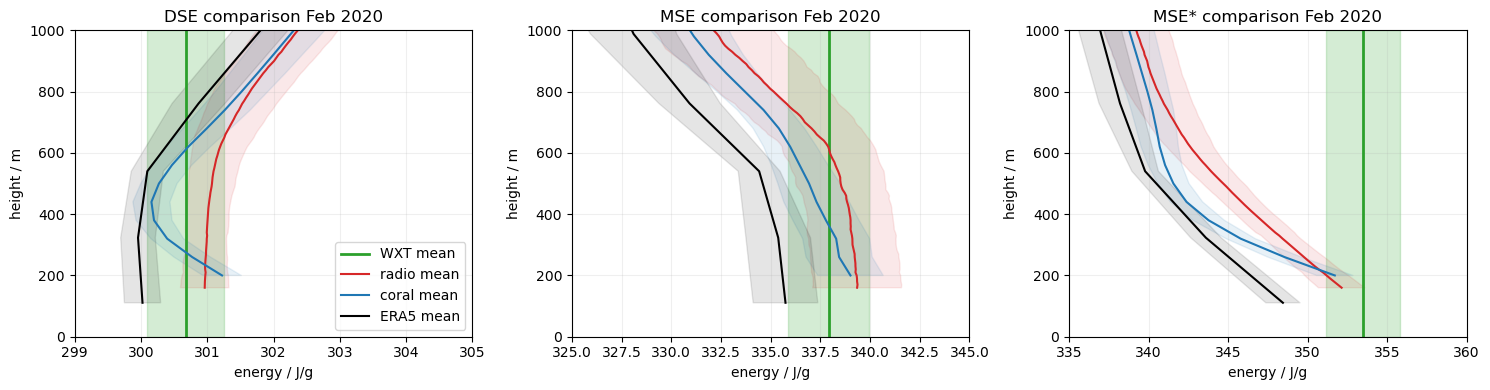

In [18]:


# ============================================================
# 3. Plot everything
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# -------------------------
# surface value
# -------------------------

axes[0].axvline(wxt_dse_mean / 1e3, color="tab:green", lw=2, label="WXT mean")

axes[0].axvspan(
    (wxt_dse_mean - wxt_dse_std)/1e3,
    (wxt_dse_mean + wxt_dse_std)/1e3,
    color="tab:green",
    alpha=0.2
)

# --- MSE subplot (axes[1]) ---
axes[1].axvline(wxt_mse_mean / 1e3, color="tab:green", lw=2, label="WXT mean")

axes[1].axvspan(
    (wxt_mse_mean - wxt_mse_std)/1e3,
    (wxt_mse_mean + wxt_mse_std)/1e3,
    color="tab:green",
    alpha=0.2
)

# --- MSE_sat subplot (axes[2]) ---
axes[2].axvline(wxt_mseSat_mean / 1e3, color="tab:green", lw=2, label="WXT mean")

axes[2].axvspan(
    (wxt_mseSat_mean - wxt_mseSat_std)/1e3,
    (wxt_mseSat_mean + wxt_mseSat_std)/1e3,
    color="tab:green",
    alpha=0.2
)





# -------------------------
# Radiosonde mean profiles + shading
# -------------------------

axes[0].plot(dse_pr_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
axes[1].plot(mse_pr_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
axes[2].plot(mse_pr_sat_mean / 1e3, alt_pr, color="tab:red", label="radio mean")

axes[0].fill_betweenx(alt_pr, (dse_pr_mean - dse_pr_std)/1e3,
                                   (dse_pr_mean + dse_pr_std)/1e3,
                                   color="tab:red", alpha=0.1)

axes[1].fill_betweenx(alt_pr, (mse_pr_mean - mse_pr_std)/1e3,
                                   (mse_pr_mean + mse_pr_std)/1e3,
                                   color="tab:red", alpha=0.1)

axes[2].fill_betweenx(alt_pr, (mse_pr_sat_mean - mse_pr_sat_std)/1e3,
                                   (mse_pr_sat_mean + mse_pr_sat_std)/1e3,
                                   color="tab:red", alpha=0.1)


# -------------------------
# CORAL mean profiles + shaded stdev
# -------------------------

axes[0].plot(DSE_day_mean/1e3, DSE_day.alt, color="tab:blue", label="coral mean")
axes[1].plot(MSE_day_mean/1e3, MSE_day.alt, color="tab:blue", label="coral mean")
axes[2].plot(MSE_sat_day_mean/1e3, MSE_sat_day.alt, color="tab:blue", label="coral mean")

axes[0].fill_betweenx(DSE_day.alt,
    (DSE_day_mean - DSE_day_std)/1e3,
    (DSE_day_mean + DSE_day_std)/1e3,
    color="tab:blue", alpha=0.1)

axes[1].fill_betweenx(MSE_day.alt,
    (MSE_day_mean - MSE_day_std)/1e3,
    (MSE_day_mean + MSE_day_std)/1e3,
    color="tab:blue", alpha=0.1)

axes[2].fill_betweenx(MSE_sat_day.alt,
    (MSE_sat_day_mean - MSE_sat_day_std)/1e3,
    (MSE_sat_day_mean + MSE_sat_day_std)/1e3,
    color="tab:blue", alpha=0.1)


# -------------------------
# ERA5 mean profiles + shaded stdev
# -------------------------

axes[0].plot(era5_dse_mean/1e3, height, color="k", label="ERA5 mean")
axes[1].plot(era5_mse_mean/1e3, height, color="k", label="ERA5 mean")
axes[2].plot(era5_mseSat_mean/1e3, height, color="k", label="ERA5 mean")

axes[0].fill_betweenx(height,
    (era5_dse_mean - era5_dse_std)/1e3,
    (era5_dse_mean + era5_dse_std)/1e3,
    color="k", alpha=0.1)

axes[1].fill_betweenx(height,
    (era5_mse_mean - era5_mse_std)/1e3,
    (era5_mse_mean + era5_mse_std)/1e3,
    color="k", alpha=0.1)

axes[2].fill_betweenx(height,
    (era5_mseSat_mean - era5_mseSat_std)/1e3,
    (era5_mseSat_mean + era5_mseSat_std)/1e3,
    color="k", alpha=0.1)


# ----------------------------------------------------------
# Formatting
# ----------------------------------------------------------
axes[0].set_title("DSE comparison Feb 2020")
axes[1].set_title("MSE comparison Feb 2020")
axes[2].set_title("MSE* comparison Feb 2020")

for ax in axes:
    ax.set_xlabel("energy / J/g")
    ax.set_ylabel("height / m")
    ax.set_ylim(0, 1000)
    ax.grid(alpha=0.2)

axes[0].legend(loc="lower right")
axes[0].set_xlim(299, 305)
axes[1].set_xlim(325, 345)
axes[2].set_xlim(335, 360)

plt.tight_layout()
plt.show()


### how do profiles compare with ceilometer?

In [15]:
path_to_ceilo = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__EUREC4A.nc"
ceilo = xr.open_dataset(path_to_ceilo)
ceilo['time'] = ceilo['time'].astype('datetime64[ns]')
ceilo = ceilo.sortby('time')
ceilo = ceilo.sel(time=slice('2020-02-01','2020-02-18'))

cbh_hr = ceilo["cbh_1"].resample(time='1h').mean()

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/num

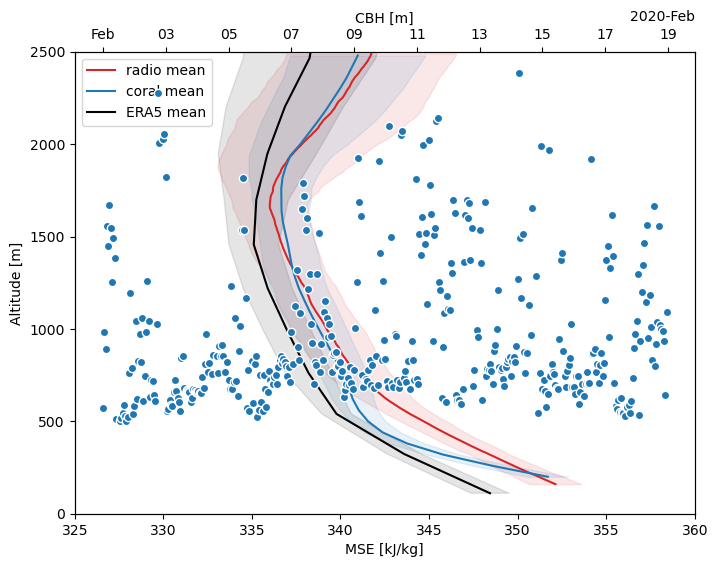

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/array/num

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,6))

# ---- Original plots on the main axes (ax1) ----
ax1.plot(mse_pr_sat_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
ax1.fill_betweenx(alt_pr,
                  (mse_pr_sat_mean - mse_pr_sat_std)/1e3,
                  (mse_pr_sat_mean + mse_pr_sat_std)/1e3,
                  color="tab:red", alpha=0.1)

ax1.plot(MSE_sat_day_mean/1e3, MSE_sat_day.alt, color="tab:blue", label="coral mean")
ax1.fill_betweenx(MSE_sat_day.alt,
                  (MSE_sat_day_mean - MSE_sat_day_std)/1e3,
                  (MSE_sat_day_mean + MSE_sat_day_std)/1e3,
                  color="tab:blue", alpha=0.1)

ax1.plot(era5_mseSat_mean/1e3, height, color="k", label="ERA5 mean")
ax1.fill_betweenx(height,
                  (era5_mseSat_mean - era5_mseSat_std)/1e3,
                  (era5_mseSat_mean + era5_mseSat_std)/1e3,
                  color="k", alpha=0.1)

ax1.set_ylim(0, 2500)
ax1.set_xlim(325,360)
ax1.set_xlabel("MSE [kJ/kg]")
ax1.set_ylabel("Altitude [m]")

# ---- Secondary x-axis on top for CBH ----
ax2 = ax1.twiny()
cbh_hr.plot.scatter(ax=ax2)
ax2.set_xlabel("CBH [m]")

# ---- Secondary y-axis on right for CBH if needed ----
# ax3 = ax1.twinx()
# ax3.plot(cbh_hr_mean.index.hour*100, cbh_hr_mean.values, 'g.', alpha=0.5)
# ax3.set_ylabel("CBH [m]")

# ---- Legends ----
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc="upper left")

plt.show()


### include theoretical LCL estimation from parcel perspective as well

In [16]:
import metpy.calc as mpcalc
from metpy.units import units

# Ensure xarray + pint units
temp_q = temp.metpy.quantify()
rh_q = rh.metpy.quantify()
p_q = sfc_pressure.metpy.quantify()

# Compute dewpoint: stays xarray with same dims
dp = mpcalc.dewpoint_from_relative_humidity(temp_q*units.K, rh_q)

# Compute LCL: returns two xarray DataArrays with same dims as temp
lcl_p, lcl_T = mpcalc.lcl(p_q, temp_q*units.K, dp)

# Convert LCL pressure to height — returns pint.Quantity, NOT xarray
lcl_h = mpcalc.pressure_to_height_std(lcl_p)

# Convert to meters
lcl_h = lcl_h.to(units.meter)

# --- FIX: rewrap into DataArray using the original coords ---
lcl_h = xr.DataArray(
    lcl_h.m,  # magnitude
    coords=temp.coords,
    dims=temp.dims,
    name='lcl_height'
)  #.metpy.quantify()  # restore pint units inside xarray

# Now resample works
lcl_h_hr = lcl_h.resample(time="1h").mean()



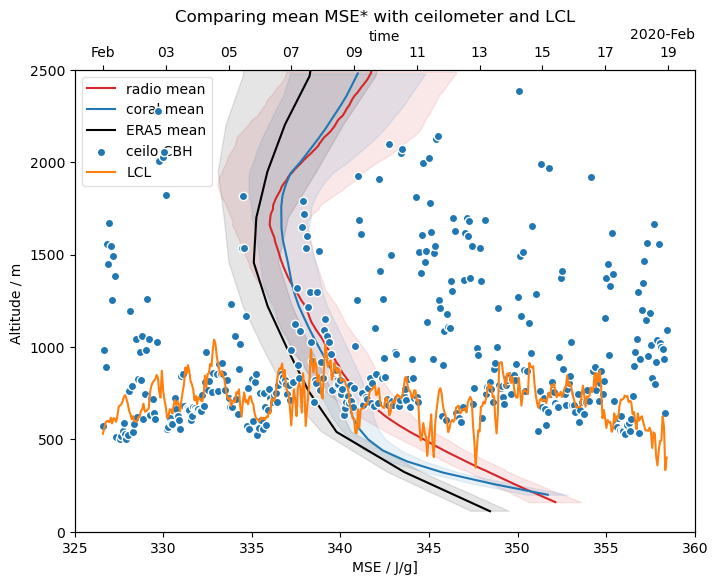

In [25]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,6))

# ---- Original plots on the main axes (ax1) ----
ax1.plot(mse_pr_sat_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
ax1.fill_betweenx(alt_pr,
                  (mse_pr_sat_mean - mse_pr_sat_std)/1e3,
                  (mse_pr_sat_mean + mse_pr_sat_std)/1e3,
                  color="tab:red", alpha=0.1)

ax1.plot(MSE_sat_day_mean/1e3, MSE_sat_day.alt, color="tab:blue", label="coral mean")
ax1.fill_betweenx(MSE_sat_day.alt,
                  (MSE_sat_day_mean - MSE_sat_day_std)/1e3,
                  (MSE_sat_day_mean + MSE_sat_day_std)/1e3,
                  color="tab:blue", alpha=0.1)

ax1.plot(era5_mseSat_mean/1e3, height, color="k", label="ERA5 mean")
ax1.fill_betweenx(height,
                  (era5_mseSat_mean - era5_mseSat_std)/1e3,
                  (era5_mseSat_mean + era5_mseSat_std)/1e3,
                  color="k", alpha=0.1)

ax1.set_ylim(0, 2500)
ax1.set_xlim(325,360)
ax1.set_xlabel("MSE / J/g]")
ax1.set_ylabel("Altitude / m ")

# ---- Secondary x-axis on top for CBH ----
ax2 = ax1.twiny()
scatter_handle = cbh_hr.plot.scatter(ax=ax2, zorder=1)
scatter_handle.set_label("ceilo CBH")
ax2.set_xlabel("time")

# ---- plot LCL ----
lcl_line, = ax2.plot(cbh_hr.time, lcl_h_hr, color="tab:orange", label='LCL')

# ---- Legends ----
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

leg = ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left" ,
           frameon=True, framealpha=0.6)
leg.set_zorder(1000) 

fig.suptitle("Comparing mean MSE* with ceilometer and LCL")

plt.show()


## open WindCube data
### $\rightarrow$ Lutz and I have concluded that data is corrupted

In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr

import glob

In [4]:
ds = xr.open_dataset("/work/mh1498/m301248/hor_wind_BCO/WindCube_202410_unzipped/wind_and_aerosols_data/0-00/WLS200s-180_2024-10-19_00-09-47_dbs_1397_25m.nc")
ds

<xarray.Dataset> Size: 144B
Dimensions:            (sweep: 1)
Coordinates:
  * sweep              (sweep) int32 4B 1
Data variables:
    instrument_type    <U5 20B ...
    lidar_model        <U4 16B ...
    latitude           float64 8B ...
    longitude          float64 8B ...
    altitude           float64 8B ...
    default_latitude   float64 8B ...
    default_longitude  float64 8B ...
    default_altitude   float64 8B ...
    sweep_group_name   (sweep) <U12 48B ...
    sweep_fixed_angle  (sweep) float64 8B ...
Attributes:
    title:            Leosphere Windcube data
    Conventions:      CF/Radial 2.0 , CF-1.7
    institution:      Leosphere
    references:       
    source:           Lidar measurements
    history:          Windcube Lidar server 3.3.4
    comment:          
    instrument_name:  WLS200s-180

In [7]:
files_dbs = sorted(glob.glob("/work/mh1498/m301248/hor_wind_BCO/WindCube_202410_unzipped/wind_and_aerosols_data/0-00/*dbs*.nc"))

# Open and concatenate
ds = xr.open_mfdataset(
    files_dbs,
    combine="nested",
    concat_dim="sweep",     # ← or any dimension you expect
)
ds

/tmp/ipykernel_405735/617760703.py:4: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(


<xarray.Dataset> Size: 4kB
Dimensions:            (sweep: 30)
Coordinates:
  * sweep              (sweep) int32 120B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Data variables:
    instrument_type    (sweep) <U5 600B 'lidar' 'lidar' ... 'lidar' 'lidar'
    lidar_model        (sweep) <U4 480B '200s' '200s' '200s' ... '200s' '200s'
    latitude           (sweep) float64 240B 13.16 13.16 13.16 ... 13.16 13.16
    longitude          (sweep) float64 240B -59.43 -59.43 ... -59.43 -59.43
    altitude           (sweep) float64 240B nan nan nan nan ... nan nan nan nan
    default_latitude   (sweep) float64 240B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    default_longitude  (sweep) float64 240B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    default_altitude   (sweep) float64 240B nan nan nan nan ... nan nan nan nan
    sweep_group_name   (sweep) <U12 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    sweep_fixed_angle  (sweep) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:            Leosphere Windcube data
    Conventions:      CF/Radial 2.0 , CF-1.7
    institution:      Leosphere
    references:       
    source:           Lidar measurements
    history:          Windcube Lidar server 3.3.4
    comment:          
    instrument_name:  WLS200s-180

### open Doppler wind profiler

In [3]:
windlidar = cat.BCO.windlidar2_c1_v1.to_dask()
windlidar

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 82GB
Dimensions:       (time: 33463547, alt: 100)
Coordinates:
  * time          (time) datetime64[ns] 268MB 2019-02-18T14:21:24.069600 ... ...
  * alt           (alt) float64 800B 36.0 66.0 96.0 ... 2.976e+03 3.006e+03
    lat           float64 8B ...
    lon           float64 8B ...
Data variables:
    azi           (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    beta          (time, alt) float64 27GB dask.array<chunksize=(8192, 32), meta=np.ndarray>
    doppler       (time, alt) float64 27GB dask.array<chunksize=(8192, 32), meta=np.ndarray>
    focus         (time) int64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    gate_length   float64 8B ...
    gates_number  int64 8B ...
    intensity     (time, alt) float64 27GB dask.array<chunksize=(8192, 32), meta=np.ndarray>
    pitch         (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    pulses        (time) int64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    resolution    float64 8B ...
    roll          (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
    zenith        (time) float64 268MB dask.array<chunksize=(262144,), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.12
    bcoproc_version:  0.0.0.post540.dev0+8fd9c92
    history:          processed with bcoproc l1
    institution:      Max Planck Institute for Meteorology, Hamburg
    license:          CC0-1.0
    location:         The Barbados Cloud Observatory, Deebles Point, Barbados...
    platform:         BCO
    source:           Halo Photonics Stream Line Pro Scanning Doppler Lidar
    summary:          The Halo Photonics Stream Line Pro Scanning Doppler Lid...
    title:            WindLidar data from BCO (Level 1)
    tool_versions:    {"Python": "3.11.2 (main, Apr 28 2025, 14:11:48) [GCC 1...

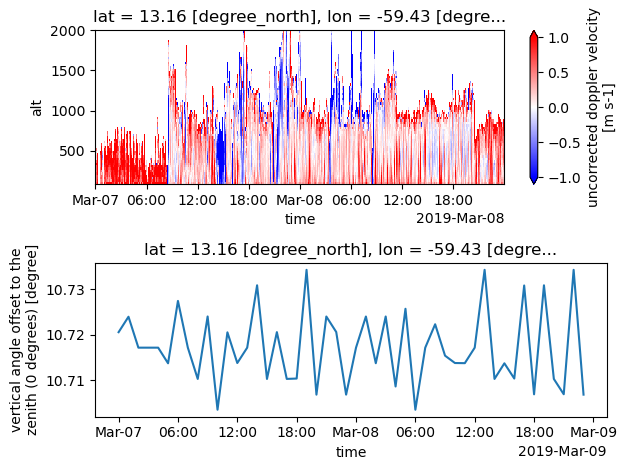

In [4]:
def is_vertical(ds):
    return ds["zenith"] < 2

def is_reliable(ds):
    # mask signals from the point where it became too much attenuated
    return (ds["intensity"] <= 1.015).cumsum("alt") < 1

# cut, filter, resample and plot the data
wl1_day = windlidar.sel(time=slice("2019-03-07", "2019-03-08"), alt=slice(70, 2000))
wl1_1min_avg = wl1_day["doppler"].where(is_reliable(wl1_day)).resample(time="1min").mean()



fig, ax = plt.subplots(2,1)
ax=ax.flatten()

wl1_1min_avg.plot(ax=ax[0], x="time", y="alt", vmin=-1, vmax=1, cmap="bwr")
wl1_day.zenith.resample(time="1h").mean().plot(ax=ax[1])

plt.tight_layout()